In [60]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import ast
from sklearn.metrics import confusion_matrix
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("feature_engineered_data.csv")

In [3]:
df.head()

,startTime,driverId,tripId,startLocation,tripDistance,tripSpeed,tripDuration,endLocation,tripFare,paymentType,...,is_business_day,15min_interval,30min_interval,60min_interval,1day_interval,startLatitude,startLongitude,endLatitude,endLongitude,tripDistance_km
0,2023-01-01 18:53:00,1,0,"[23.075897, 72.483299]",11.8,24.97,28,"[23.075855, 72.598551]",124,upi,...,0,2023-01-01 18:45:00,2023-01-01 18:30:00,2023-01-01 18:00:00,2023-01-01,23.075897,72.483299,23.075855,72.598551,18.990212
1,2023-01-01 20:39:00,1,1,"[23.002, 72.550009]",8.5,15.34,33,"[23.072137, 72.583952]",91,upi,...,0,2023-01-01 20:30:00,2023-01-01 20:30:00,2023-01-01 20:00:00,2023-01-01,23.002000,72.550009,23.072137,72.583952,13.679390
2,2023-01-01 21:24:00,1,2,"[22.929988, 72.578228]",13.4,27.74,29,"[23.050404, 72.578228]",140,cash,...,0,2023-01-01 21:15:00,2023-01-01 21:00:00,2023-01-01 21:00:00,2023-01-01,22.929988,72.578228,23.050404,72.578228,21.565156
3,2023-01-01 21:58:00,1,3,"[23.029391, 72.555201]",6.3,14.47,26,"[23.061703, 72.605368]",69,cash,...,0,2023-01-01 21:45:00,2023-01-01 21:30:00,2023-01-01 21:00:00,2023-01-01,23.029391,72.555201,23.061703,72.605368,10.138842
4,2023-01-01 22:47:00,1,4,"[23.067932, 72.51617]",5.7,13.42,25,"[23.103956, 72.55534]",63,upi,...,0,2023-01-01 22:45:00,2023-01-01 22:30:00,2023-01-01 22:00:00,2023-01-01,23.067932,72.516170,23.103956,72.555340,9.173238


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44718 entries, 0 to 44717
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   startTime        44718 non-null  object 
 1   driverId         44718 non-null  int64  
 2   tripId           44718 non-null  int64  
 3   startLocation    44718 non-null  object 
 4   tripDistance     44718 non-null  float64
 5   tripSpeed        44718 non-null  float64
 6   tripDuration     44718 non-null  int64  
 7   endLocation      44718 non-null  object 
 8   tripFare         44718 non-null  int64  
 9   paymentType      44718 non-null  object 
 10  endTime          44718 non-null  object 
 11  latitude         44718 non-null  float64
 12  longitude        44718 non-null  float64
 13  latitude_bin     44718 non-null  object 
 14  longitude_bin    44718 non-null  object 
 15  time_interval    44718 non-null  object 
 16  day_of_week      44718 non-null  int64  
 17  hour_of_day 

## 1. XGBoost 

In [5]:
demand_data = df.groupby('15min_interval').size().reset_index(name='demand')

In [6]:
df = pd.merge(df, demand_data, on='15min_interval', how='left')

In [7]:
df.head()

,startTime,driverId,tripId,startLocation,tripDistance,tripSpeed,tripDuration,endLocation,tripFare,paymentType,...,15min_interval,30min_interval,60min_interval,1day_interval,startLatitude,startLongitude,endLatitude,endLongitude,tripDistance_km,demand
0,2023-01-01 18:53:00,1,0,"[23.075897, 72.483299]",11.8,24.97,28,"[23.075855, 72.598551]",124,upi,...,2023-01-01 18:45:00,2023-01-01 18:30:00,2023-01-01 18:00:00,2023-01-01,23.075897,72.483299,23.075855,72.598551,18.990212,4
1,2023-01-01 20:39:00,1,1,"[23.002, 72.550009]",8.5,15.34,33,"[23.072137, 72.583952]",91,upi,...,2023-01-01 20:30:00,2023-01-01 20:30:00,2023-01-01 20:00:00,2023-01-01,23.002000,72.550009,23.072137,72.583952,13.679390,7
2,2023-01-01 21:24:00,1,2,"[22.929988, 72.578228]",13.4,27.74,29,"[23.050404, 72.578228]",140,cash,...,2023-01-01 21:15:00,2023-01-01 21:00:00,2023-01-01 21:00:00,2023-01-01,22.929988,72.578228,23.050404,72.578228,21.565156,2
3,2023-01-01 21:58:00,1,3,"[23.029391, 72.555201]",6.3,14.47,26,"[23.061703, 72.605368]",69,cash,...,2023-01-01 21:45:00,2023-01-01 21:30:00,2023-01-01 21:00:00,2023-01-01,23.029391,72.555201,23.061703,72.605368,10.138842,3
4,2023-01-01 22:47:00,1,4,"[23.067932, 72.51617]",5.7,13.42,25,"[23.103956, 72.55534]",63,upi,...,2023-01-01 22:45:00,2023-01-01 22:30:00,2023-01-01 22:00:00,2023-01-01,23.067932,72.516170,23.103956,72.555340,9.173238,19


In [8]:
features = ['hour_of_day', 'day_of_week', 'month', 'year', 'is_peak_hour', 'is_business_day']

In [9]:
target = 'demand'


In [12]:
# Train-Test Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [13]:
# XGBoost Model Training
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(train_df[features], train_df[target])


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [14]:
# XGBoost Model Prediction
xgb_predictions = xgb_model.predict(test_df[features])

In [15]:
# XGBoost Model Evaluation
mae_xgb = mean_absolute_error(test_df[target], xgb_predictions)
print(f'XGBoost Mean Absolute Error: {mae_xgb}')

XGBoost Mean Absolute Error: 4.66298947555941


In [21]:
# Confusion Matrix
threshold = 0.5
binary_xgb_predictions = (xgb_predictions > threshold).astype(int)
binary_actual_demand = (test_df[target] > threshold).astype(int)
conf_matrix_xgb = confusion_matrix(binary_actual_demand, binary_xgb_predictions)


In [22]:
print("Confusion Matrix for XGBoost Model:")
print(conf_matrix_xgb)

Confusion Matrix for XGBoost Model:
[[8944]]


In [23]:
df.head()

,startTime,driverId,tripId,startLocation,tripDistance,tripSpeed,tripDuration,endLocation,tripFare,paymentType,...,15min_interval,30min_interval,60min_interval,1day_interval,startLatitude,startLongitude,endLatitude,endLongitude,tripDistance_km,demand
0,2023-01-01 18:53:00,1,0,"[23.075897, 72.483299]",11.8,24.97,28,"[23.075855, 72.598551]",124,upi,...,2023-01-01 18:45:00,2023-01-01 18:30:00,2023-01-01 18:00:00,2023-01-01,23.075897,72.483299,23.075855,72.598551,18.990212,4
1,2023-01-01 20:39:00,1,1,"[23.002, 72.550009]",8.5,15.34,33,"[23.072137, 72.583952]",91,upi,...,2023-01-01 20:30:00,2023-01-01 20:30:00,2023-01-01 20:00:00,2023-01-01,23.002000,72.550009,23.072137,72.583952,13.679390,7
2,2023-01-01 21:24:00,1,2,"[22.929988, 72.578228]",13.4,27.74,29,"[23.050404, 72.578228]",140,cash,...,2023-01-01 21:15:00,2023-01-01 21:00:00,2023-01-01 21:00:00,2023-01-01,22.929988,72.578228,23.050404,72.578228,21.565156,2
3,2023-01-01 21:58:00,1,3,"[23.029391, 72.555201]",6.3,14.47,26,"[23.061703, 72.605368]",69,cash,...,2023-01-01 21:45:00,2023-01-01 21:30:00,2023-01-01 21:00:00,2023-01-01,23.029391,72.555201,23.061703,72.605368,10.138842,3
4,2023-01-01 22:47:00,1,4,"[23.067932, 72.51617]",5.7,13.42,25,"[23.103956, 72.55534]",63,upi,...,2023-01-01 22:45:00,2023-01-01 22:30:00,2023-01-01 22:00:00,2023-01-01,23.067932,72.516170,23.103956,72.555340,9.173238,19


In [24]:
print(xgb_predictions)

[10.024226  13.171498  41.858276  ...  5.911425   4.6904907 16.521643 ]


## 2. ARIMA Model

In [30]:
# ARIMA Model Training
demand_data = df.groupby('15min_interval').size()
arima_model = ARIMA(demand_data, order=(1, 1, 1))  # Example order, tune as needed
arima_results = arima_model.fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [31]:
# ARIMA Model Prediction
arima_predictions = arima_results.predict(start=len(demand_data), end=len(demand_data) + len(test_df) - 1, typ='levels')

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [32]:
# ARIMA Model Evaluation
mae_arima = mean_absolute_error(test_df[target], arima_predictions)
print(f'ARIMA Mean Absolute Error: {mae_arima}')

ARIMA Mean Absolute Error: 11.458862951338025


## 3. DNN Model:

In [43]:
df.drop('demand', axis=1)

,startTime,driverId,tripId,startLocation,tripDistance,tripSpeed,tripDuration,endLocation,tripFare,paymentType,...,15min_interval,30min_interval,60min_interval,1day_interval,startLatitude,startLongitude,endLatitude,endLongitude,tripDistance_km,demand_x
0,2023-01-01 18:53:00,1,0,"[23.075897, 72.483299]",11.8,24.97,28,"[23.075855, 72.598551]",124,upi,...,2023-01-01 18:45:00,2023-01-01 18:30:00,2023-01-01 18:00:00,2023-01-01,23.075897,72.483299,23.075855,72.598551,18.990212,4
1,2023-01-01 20:39:00,1,1,"[23.002, 72.550009]",8.5,15.34,33,"[23.072137, 72.583952]",91,upi,...,2023-01-01 20:30:00,2023-01-01 20:30:00,2023-01-01 20:00:00,2023-01-01,23.002000,72.550009,23.072137,72.583952,13.679390,7
2,2023-01-01 21:24:00,1,2,"[22.929988, 72.578228]",13.4,27.74,29,"[23.050404, 72.578228]",140,cash,...,2023-01-01 21:15:00,2023-01-01 21:00:00,2023-01-01 21:00:00,2023-01-01,22.929988,72.578228,23.050404,72.578228,21.565156,2
3,2023-01-01 21:58:00,1,3,"[23.029391, 72.555201]",6.3,14.47,26,"[23.061703, 72.605368]",69,cash,...,2023-01-01 21:45:00,2023-01-01 21:30:00,2023-01-01 21:00:00,2023-01-01,23.029391,72.555201,23.061703,72.605368,10.138842,3
4,2023-01-01 22:47:00,1,4,"[23.067932, 72.51617]",5.7,13.42,25,"[23.103956, 72.55534]",63,upi,...,2023-01-01 22:45:00,2023-01-01 22:30:00,2023-01-01 22:00:00,2023-01-01,23.067932,72.516170,23.103956,72.555340,9.173238,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44713,2023-07-30 22:17:00,59,7335,"[23.020004, 72.538292]",12.7,27.89,27,"[23.085644, 72.640247]",133,cash,...,2023-07-30 22:15:00,2023-07-30 22:00:00,2023-07-30 22:00:00,2023-07-30,23.020004,72.538292,23.085644,72.640247,20.438618,18
44714,2023-07-30 22:56:00,59,7336,"[22.930191999999998, 72.603644]",2.5,26.47,6,"[22.945845, 72.620643]",31,cash,...,2023-07-30 22:45:00,2023-07-30 22:30:00,2023-07-30 22:00:00,2023-07-30,22.930192,72.603644,22.945845,72.620643,4.023350,26
44715,2023-07-31 19:47:00,59,7337,"[22.969975, 72.488663]",7.8,23.32,20,"[23.010283, 72.551224]",84,upi,...,2023-07-31 19:45:00,2023-07-31 19:30:00,2023-07-31 19:00:00,2023-07-31,22.969975,72.488663,23.010283,72.551224,12.552852,6
44716,2023-07-31 22:13:00,59,7338,"[23.124911, 72.486731]",9.7,27.07,21,"[23.124883, 72.581246]",103,cash,...,2023-07-31 22:00:00,2023-07-31 22:00:00,2023-07-31 22:00:00,2023-07-31,23.124911,72.486731,23.124883,72.581246,15.610598,12


In [45]:
# Aggregate data to represent the count of trips within each 15-minute interval
demand_data = df.groupby('15min_interval').size().reset_index(name='demand')

# Merge demand data back to the original DataFrame
df = pd.merge(df, demand_data, on='15min_interval', how='left')

In [46]:
# Select features for modeling
features = ['hour_of_day', 'day_of_week', 'month', 'year', 'is_peak_hour', 'is_business_day']

In [47]:
# Target variable
target = 'demand'

In [48]:
# Train-Test Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [49]:
# DNN Model Training
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(len(features),)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

In [50]:
model.compile(optimizer='adam', loss='mae')  # Mean Absolute Error (MAE) loss for regression
model.fit(train_df[features], train_df[target], epochs=50, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/50

895/895 - 2s - loss: 12.3368 - val_loss: 20.4369 - 2s/epoch - 3ms/step
Epoch 2/50
895/895 - 1s - loss: 10.9186 - val_loss: 10.6411 - 1s/epoch - 2ms/step
Epoch 3/50
895/895 - 1s - loss: 10.7564 - val_loss: 8.9898 - 1s/epoch - 2ms/step
Epoch 4/50
895/895 - 1s - loss: 10.2925 - val_loss: 9.1666 - 1s/epoch - 2ms/step
Epoch 5/50
895/895 - 1s - loss: 10.1117 - val_loss: 9.8227 - 1s/epoch - 2ms/step
Epoch 6/50
895/895 - 1s - loss: 9.8078 - val_loss: 10.0289 - 1s/epoch - 2ms/step
Epoch 7/50
895/895 - 1s - loss: 9.8722 - val_loss: 9.6987 - 1s/epoch - 2ms/step
Epoch 8/50
895/895 - 1s - loss: 9.8078 - val_loss: 8.9345 - 1s/epoch - 2ms/step
Epoch 9/50
895/895 - 1s - loss: 9.6995 - val_loss: 11.1073 - 1s/epoch - 2ms/step
Epoch 10/50
895/895 - 1s - loss: 9.6911 - val_loss: 11.3690 - 1s/epoch - 2ms/step
Epoch 11/50
895/895 - 1s - loss: 9.5554 - val_loss: 8.9301 - 1s/epoch - 2ms/step
Epoch 12/50
895/895 - 1s - loss: 9.5472 - val_loss: 8.9444 - 1s/epoch - 2ms/step
Epoch 13/50
895/895 - 1s -

In [51]:
# DNN Model Prediction
dnn_predictions = model.predict(test_df[features])

280/280 [==============================] - 1s 1ms/step


In [52]:
# DNN Model Evaluation
mae_dnn = mean_absolute_error(test_df[target], dnn_predictions)
print(f'DNN Mean Absolute Error: {mae_dnn}')

DNN Mean Absolute Error: 6.49902507221936


In [53]:
binary_arima_predictions = (arima_predictions > threshold).astype(int)
binary_dnn_predictions = (dnn_predictions > threshold).astype(int)


In [54]:
# Calculate confusion matrices
conf_matrix_xgb = confusion_matrix(binary_actual_demand, binary_xgb_predictions)
conf_matrix_arima = confusion_matrix(binary_actual_demand, binary_arima_predictions)
conf_matrix_dnn = confusion_matrix(binary_actual_demand, binary_dnn_predictions)

In [55]:
print("Confusion Matrix for XGBoost Model:")
print(conf_matrix_xgb)

print("\nConfusion Matrix for ARIMA Model:")
print(conf_matrix_arima)

print("\nConfusion Matrix for DNN Model:")
print(conf_matrix_dnn)

Confusion Matrix for XGBoost Model:
[[8944]]

Confusion Matrix for ARIMA Model:
[[8944]]

Confusion Matrix for DNN Model:
[[   0    0]
 [ 129 8815]]


In [56]:
# Append predictions to the DataFrame
test_df['xgb_predictions'] = xgb_predictions
test_df['arima_predictions'] = arima_predictions
test_df['dnn_predictions'] = dnn_predictions

In [57]:
df.head()

,startTime,driverId,tripId,startLocation,tripDistance,tripSpeed,tripDuration,endLocation,tripFare,paymentType,...,60min_interval,1day_interval,startLatitude,startLongitude,endLatitude,endLongitude,tripDistance_km,demand_x,demand_y,demand
0,2023-01-01 18:53:00,1,0,"[23.075897, 72.483299]",11.8,24.97,28,"[23.075855, 72.598551]",124,upi,...,2023-01-01 18:00:00,2023-01-01,23.075897,72.483299,23.075855,72.598551,18.990212,4,4,4
1,2023-01-01 20:39:00,1,1,"[23.002, 72.550009]",8.5,15.34,33,"[23.072137, 72.583952]",91,upi,...,2023-01-01 20:00:00,2023-01-01,23.002000,72.550009,23.072137,72.583952,13.679390,7,7,7
2,2023-01-01 21:24:00,1,2,"[22.929988, 72.578228]",13.4,27.74,29,"[23.050404, 72.578228]",140,cash,...,2023-01-01 21:00:00,2023-01-01,22.929988,72.578228,23.050404,72.578228,21.565156,2,2,2
3,2023-01-01 21:58:00,1,3,"[23.029391, 72.555201]",6.3,14.47,26,"[23.061703, 72.605368]",69,cash,...,2023-01-01 21:00:00,2023-01-01,23.029391,72.555201,23.061703,72.605368,10.138842,3,3,3
4,2023-01-01 22:47:00,1,4,"[23.067932, 72.51617]",5.7,13.42,25,"[23.103956, 72.55534]",63,upi,...,2023-01-01 22:00:00,2023-01-01,23.067932,72.516170,23.103956,72.555340,9.173238,19,19,19


In [58]:
test_df.head()

,startTime,driverId,tripId,startLocation,tripDistance,tripSpeed,tripDuration,endLocation,tripFare,paymentType,...,startLongitude,endLatitude,endLongitude,tripDistance_km,demand_x,demand_y,demand,xgb_predictions,arima_predictions,dnn_predictions
39293,2023-07-14 08:50:00,16,1915,"[23.009217, 72.625755]",8.7,16.30,32,"[23.073629, 72.674785]",93,cash,...,72.625755,23.073629,72.674785,14.001258,11,11,11,10.024226,NaN,5.604633
18650,2023-04-30 08:36:00,84,10782,"[22.932691, 72.556736]",12.3,17.36,42,"[23.023187, 72.625597]",129,cash,...,72.556736,23.023187,72.625597,19.794882,11,11,11,13.171498,4.288052,3.190096
27321,2023-05-21 22:41:00,51,6711,"[23.064152, 72.52264]",5.4,17.46,18,"[23.064143, 72.575092]",60,cash,...,72.522640,23.064143,72.575092,8.690436,37,37,37,41.858276,NaN,31.012199
32047,2023-05-21 08:11:00,86,11437,"[22.978254, 72.621842]",2.5,27.28,5,"[23.000296, 72.621842]",31,cash,...,72.621842,23.000296,72.621842,4.023350,11,11,11,12.068745,NaN,4.041243
40649,2023-07-20 19:59:00,27,3271,"[23.047317, 72.548076]",4.5,20.92,13,"[23.070396, 72.583907]",51,cash,...,72.548076,23.070396,72.583907,7.242030,5,5,5,4.756568,NaN,3.729901


## 1. Line Plot of Actual Demand vs. Model Predictions

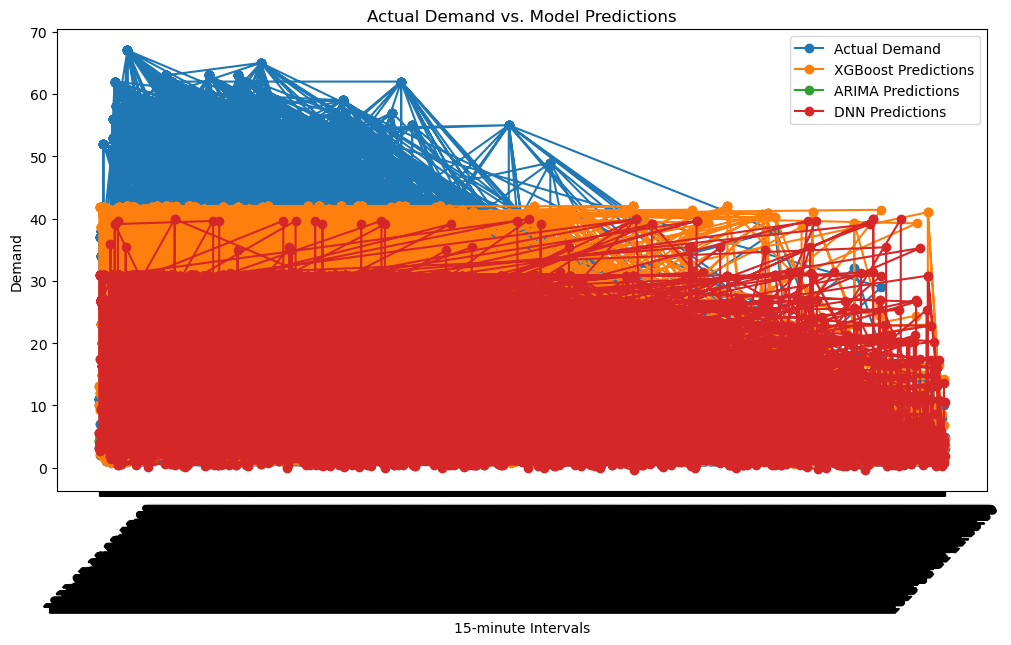

In [61]:
plt.figure(figsize=(12, 6))

# Plot actual demand
plt.plot(test_df['15min_interval'], test_df['demand'], label='Actual Demand', marker='o')

# Plot XGBoost predictions
plt.plot(test_df['15min_interval'], test_df['xgb_predictions'], label='XGBoost Predictions', marker='o')

# Plot ARIMA predictions
plt.plot(test_df['15min_interval'], test_df['arima_predictions'], label='ARIMA Predictions', marker='o')

# Plot DNN predictions
plt.plot(test_df['15min_interval'], test_df['dnn_predictions'], label='DNN Predictions', marker='o')

plt.title('Actual Demand vs. Model Predictions')
plt.xlabel('15-minute Intervals')
plt.ylabel('Demand')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## 2. Scatter Plot of Actual vs. Predicted Demand


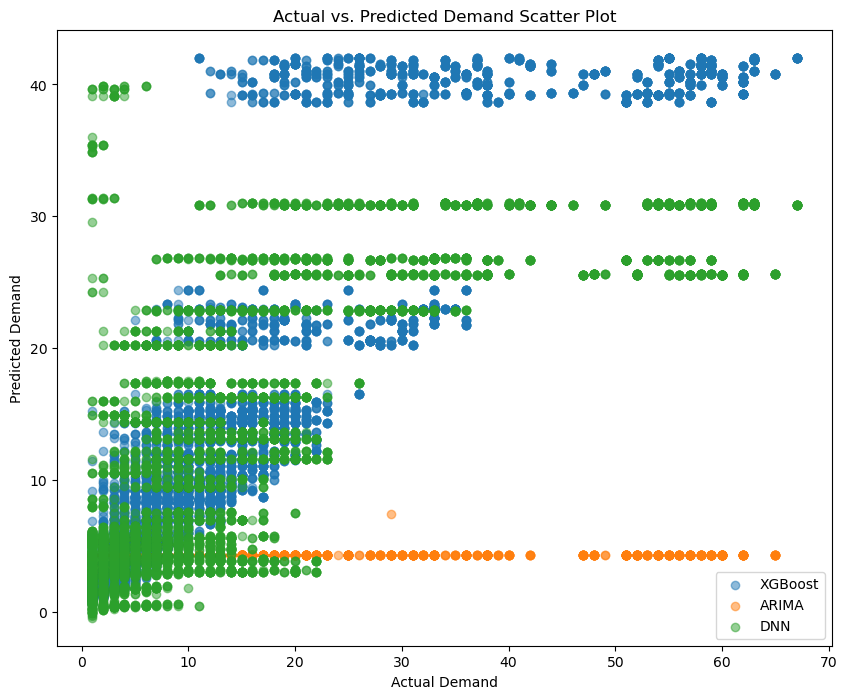

In [62]:
plt.figure(figsize=(10, 8))

# Scatter plot for XGBoost
plt.scatter(test_df['demand'], test_df['xgb_predictions'], label='XGBoost', alpha=0.5)

# Scatter plot for ARIMA
plt.scatter(test_df['demand'], test_df['arima_predictions'], label='ARIMA', alpha=0.5)

# Scatter plot for DNN
plt.scatter(test_df['demand'], test_df['dnn_predictions'], label='DNN', alpha=0.5)

plt.title('Actual vs. Predicted Demand Scatter Plot')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.legend()
plt.show()


## 3. Distribution of Residuals

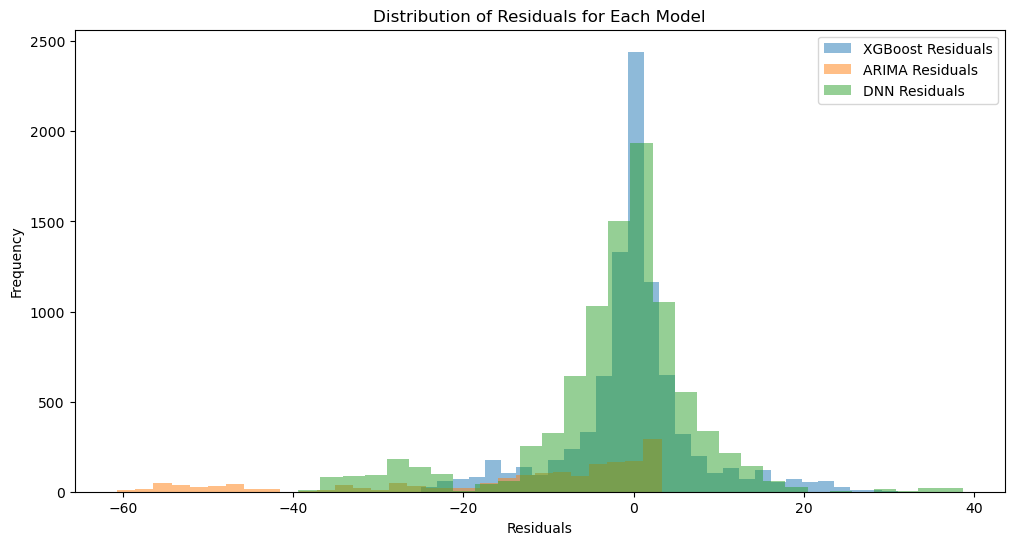

In [63]:
plt.figure(figsize=(12, 6))

# Calculate residuals for each model
xgb_residuals = test_df['xgb_predictions'] - test_df['demand']
arima_residuals = test_df['arima_predictions'] - test_df['demand']
dnn_residuals = test_df['dnn_predictions'] - test_df['demand']

# Plot histograms of residuals
plt.hist(xgb_residuals, bins=30, alpha=0.5, label='XGBoost Residuals')
plt.hist(arima_residuals, bins=30, alpha=0.5, label='ARIMA Residuals')
plt.hist(dnn_residuals, bins=30, alpha=0.5, label='DNN Residuals')

plt.title('Distribution of Residuals for Each Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## DNN has  better accuracy in predictions